# Exploring Interpretable Machine Learning in Python

Objective: An exploration into using SHAP values when feature independence does not hold true.

Methodology: 
Using "Peeking into the Black Box" as the baseline:  
    - https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3595944  
    - https://github.com/actuarial-data-science/Tutorials/blob/master/8%20-%20Peeking%20into%20the%20Black%20Box/p02_descriptive.R
- using Python instead of R
- With the ultimate focus on SHAP on tree-based models (i.e. TreeSHAP rather than KernelSHAP), the glm and NN fits not covered further.

## 1. Introduction and overview  
TODO2

## 2. Data and descriptive statistics

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap

In [42]:
freMTPL2freq = pd.read_csv("../data/freMTPL2freq.csv")
freMTPL2freq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IDpol       678013 non-null  int64  
 1   ClaimNb     678013 non-null  int64  
 2   Exposure    678013 non-null  float64
 3   Area        678013 non-null  object 
 4   VehPower    678013 non-null  int64  
 5   VehAge      678013 non-null  int64  
 6   DrivAge     678013 non-null  int64  
 7   BonusMalus  678013 non-null  int64  
 8   VehBrand    678013 non-null  object 
 9   VehGas      678013 non-null  object 
 10  Density     678013 non-null  int64  
 11  Region      678013 non-null  object 
dtypes: float64(1), int64(7), object(4)
memory usage: 62.1+ MB


In [43]:
print(freMTPL2freq.head(9))

   IDpol  ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  BonusMalus  \
0      1        1      0.10    D         5       0       55          50   
1      3        1      0.77    D         5       0       55          50   
2      5        1      0.75    B         6       2       52          50   
3     10        1      0.09    B         7       0       46          50   
4     11        1      0.84    B         7       0       46          50   
5     13        1      0.52    E         6       2       38          50   
6     15        1      0.45    E         6       2       38          50   
7     17        1      0.27    C         7       0       33          68   
8     18        1      0.71    C         7       0       33          68   

  VehBrand   VehGas  Density Region  
0      B12  Regular     1217    R82  
1      B12  Regular     1217    R82  
2      B12   Diesel       54    R22  
3      B12   Diesel       76    R72  
4      B12   Diesel       76    R72  
5      B12  Regular  

In [44]:
# Creating a distinct DataFrame
distinct = (freMTPL2freq
            .drop(columns=['IDpol', 'Exposure', 'ClaimNb'])
            .drop_duplicates()
            .reset_index(drop=True))
distinct['group_id'] = distinct.index + 1

In [45]:
distinct

,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,group_id
0,D,5,0,55,50,B12,Regular,1217,R82,1
1,B,6,2,52,50,B12,Diesel,54,R22,2
2,B,7,0,46,50,B12,Diesel,76,R72,3
3,E,6,2,38,50,B12,Regular,3003,R31,4
4,C,7,0,33,68,B12,Diesel,137,R91,5
...,...,...,...,...,...,...,...,...,...,...
528760,E,4,0,54,50,B12,Regular,3317,R93,528761
528761,E,4,0,41,95,B12,Regular,9850,R11,528762
528762,D,6,2,45,50,B12,Diesel,1323,R82,528763
528763,B,4,0,60,50,B12,Regular,95,R26,528764


In [46]:
# Joining with the original DataFrame 
dat = freMTPL2freq.merge(distinct, how='left', on=list(distinct.columns[:-1]))

In [47]:
dat

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,group_id
0,1,1,0.10000,D,5,0,55,50,B12,Regular,1217,R82,1
1,3,1,0.77000,D,5,0,55,50,B12,Regular,1217,R82,1
2,5,1,0.75000,B,6,2,52,50,B12,Diesel,54,R22,2
3,10,1,0.09000,B,7,0,46,50,B12,Diesel,76,R72,3
4,11,1,0.84000,B,7,0,46,50,B12,Diesel,76,R72,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326,0,0.00274,E,4,0,54,50,B12,Regular,3317,R93,528761
678009,6114327,0,0.00274,E,4,0,41,95,B12,Regular,9850,R11,528762
678010,6114328,0,0.00274,D,6,2,45,50,B12,Diesel,1323,R82,528763
678011,6114329,0,0.00274,B,4,0,60,50,B12,Regular,95,R26,528764


In [48]:
# Performing transformations
dat['Exposure'] = dat['Exposure'].clip(upper=1)
dat['Freq'] = dat['ClaimNb'] / dat['Exposure']
dat['Freq'] = dat['Freq'].clip(upper=15)
dat['VehPower'] = dat['VehPower'].clip(upper=12)
dat['VehAge'] = dat['VehAge'].clip(upper=20)
dat['VehGas'] = pd.Categorical(dat['VehGas'])
dat['DrivAge'] = dat['DrivAge'].clip(upper=85)
dat['logDensity'] = np.log(dat['Density'])
dat['VehBrand'] = pd.Categorical(dat['VehBrand'], categories=[f"B{i}" for i in [12, 1, 2, 3, 4, 5, 6, 10, 11, 13, 14]])
dat['PolicyRegion'] = pd.Categorical(dat['Region']).reorder_categories(['R24'] + [cat for cat in dat['Region'].unique() if cat != 'R24'], ordered=True)
dat['AreaCode'] = pd.Categorical(dat['Area'])

In [49]:
# Display frequency of each group_id
print(dat['group_id'].value_counts())

group_id
283967    22
383882    18
159370    15
263266    15
262503    15
          ..
242618     1
242617     1
242616     1
242615     1
528765     1
Name: count, Length: 528765, dtype: int64


In [50]:
# Display rows where group_id equals 283967
print(dat[dat['group_id'] == 283967])

          IDpol  ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  \
352235  2285383        0      0.66    B         9       3       35   
352236  2285384        0      0.66    B         9       3       35   
352238  2285386        0      0.66    B         9       3       35   
352239  2285387        0      0.66    B         9       3       35   
352240  2285388        0      0.66    B         9       3       35   
352241  2285389        0      0.66    B         9       3       35   
352242  2285390        0      0.66    B         9       3       35   
352243  2285391        0      0.66    B         9       3       35   
352244  2285392        0      0.66    B         9       3       35   
352245  2285393        0      0.66    B         9       3       35   
352246  2285394        0      0.66    B         9       3       35   
352247  2285395        0      0.66    B         9       3       35   
352248  2285396        0      0.66    B         9       3       35   
352249  2285397     

In [51]:
dat.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,group_id,Freq,logDensity,PolicyRegion,AreaCode
0,1,1,0.10,D,5,0,55,50,B12,Regular,1217,R82,1,10.000000,7.104144,R82,D
1,3,1,0.77,D,5,0,55,50,B12,Regular,1217,R82,1,1.298701,7.104144,R82,D
2,5,1,0.75,B,6,2,52,50,B12,Diesel,54,R22,2,1.333333,3.988984,R22,B
3,10,1,0.09,B,7,0,46,50,B12,Diesel,76,R72,3,11.111111,4.330733,R72,B
4,11,1,0.84,B,7,0,46,50,B12,Diesel,76,R72,3,1.190476,4.330733,R72,B


In [52]:
# Number of rows in dat
print(len(dat))

678013


In [53]:
print(dat.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   IDpol         678013 non-null  int64   
 1   ClaimNb       678013 non-null  int64   
 2   Exposure      678013 non-null  float64 
 3   Area          678013 non-null  object  
 4   VehPower      678013 non-null  int64   
 5   VehAge        678013 non-null  int64   
 6   DrivAge       678013 non-null  int64   
 7   BonusMalus    678013 non-null  int64   
 8   VehBrand      678013 non-null  category
 9   VehGas        678013 non-null  category
 10  Density       678013 non-null  int64   
 11  Region        678013 non-null  object  
 12  group_id      678013 non-null  int64   
 13  Freq          678013 non-null  float64 
 14  logDensity    678013 non-null  float64 
 15  PolicyRegion  678013 non-null  category
 16  AreaCode      678013 non-null  category
dtypes: category(4), float64(3), i

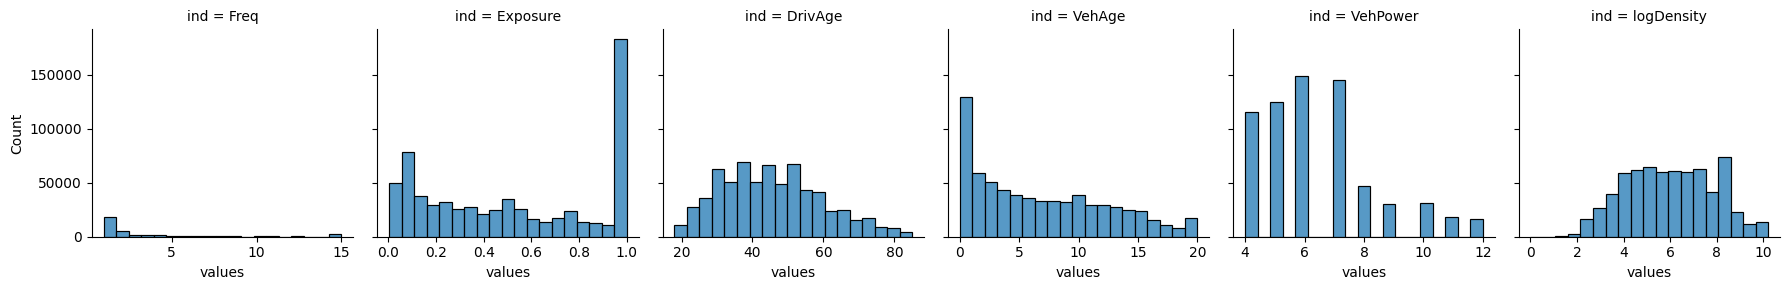

In [54]:
melted = dat[['Freq', 'Exposure', 'DrivAge', 'VehAge', 'VehPower', 'logDensity']].stack().reset_index(level=1).rename(columns={'level_1': 'ind', 0: 'values'})
melted = melted[(melted['ind'] != 'Freq') | (melted['values'] > 0)]

g = sns.FacetGrid(melted, col="ind", sharex=False)
g.map(sns.histplot, "values", bins=19, fill="#E69F00")
plt.show()

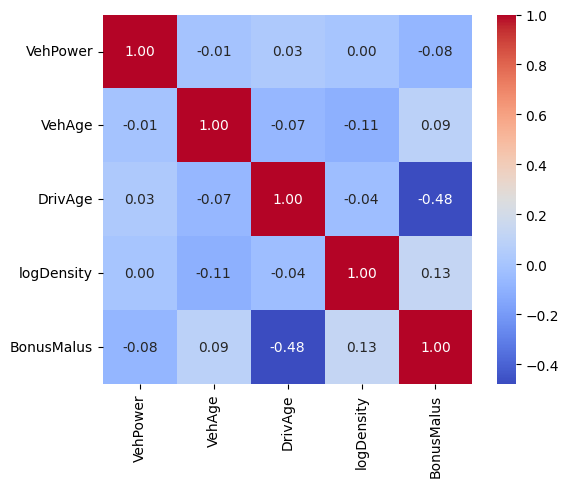

In [55]:
xtemp = ["VehPower", "VehAge", "VehBrand", "VehGas", "DrivAge", "logDensity", "PolicyRegion"]
cor_mat = dat[xtemp + ["BonusMalus"]].select_dtypes(include=[np.number]).corr().round(2)
sns.heatmap(cor_mat, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.show()

In [56]:
# Define the bins for the age categorization
bins = list(range(18, 27)) + [36, 46, 56, 66, 76, 86]
# Define the labels for each bin
labels = [str(age) for age in range(18, 26)] + ["26-35", "36-45", "46-55", "56-65", "66-75", "76+"]
# Use pandas.cut to categorize 'DrivAge'
dat['DrivAge2'] = pd.cut(dat['DrivAge'], bins=bins, labels=labels, include_lowest=True, right=True)

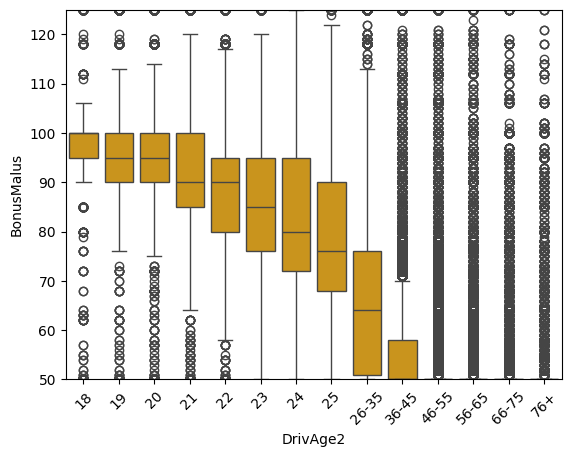

In [57]:
sns.boxplot(data=dat, x='DrivAge2', y='BonusMalus', color="#E69F00")

plt.xticks(rotation=45)
plt.ylim(50, 125)
plt.show()

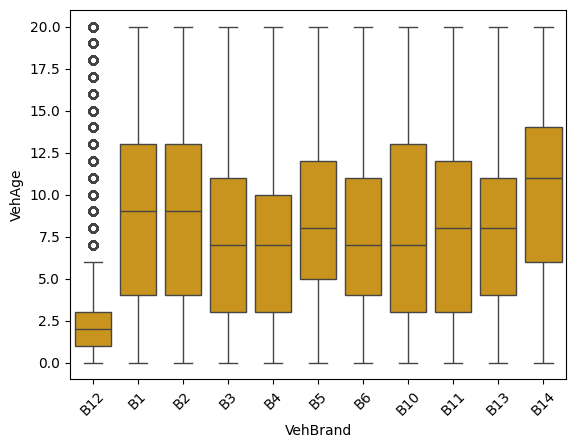

In [58]:
# Brand/Vehicle Age
sns.boxplot(data=dat, x='VehBrand', y='VehAge', color="#E69F00")
plt.xticks(rotation=45)
plt.show()

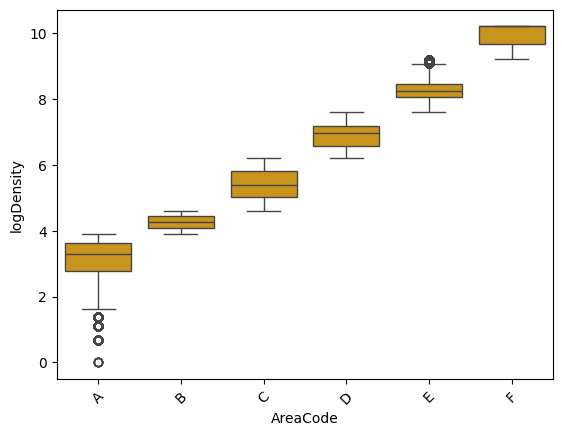

In [59]:
# Sort the dataframe by 'AreaCode' in alphabetical order
dat_sorted = dat.sort_values(by='AreaCode')
sns.boxplot(data=dat_sorted, x='AreaCode', y='logDensity', color="#E69F00")
plt.xticks(rotation=45)
plt.show()

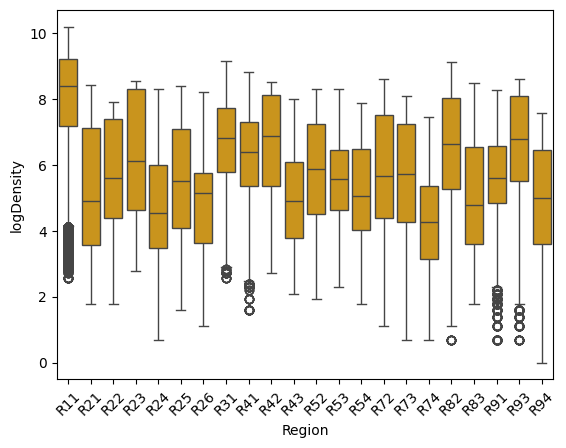

In [60]:
# Density/Region
dat_sorted2 = dat.sort_values(by='Region')
sns.boxplot(data=dat_sorted2, x='Region', y='logDensity', color="#E69F00")
plt.xticks(rotation=45)
plt.show()

In [61]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   IDpol         678013 non-null  int64   
 1   ClaimNb       678013 non-null  int64   
 2   Exposure      678013 non-null  float64 
 3   Area          678013 non-null  object  
 4   VehPower      678013 non-null  int64   
 5   VehAge        678013 non-null  int64   
 6   DrivAge       678013 non-null  int64   
 7   BonusMalus    678013 non-null  int64   
 8   VehBrand      678013 non-null  category
 9   VehGas        678013 non-null  category
 10  Density       678013 non-null  int64   
 11  Region        678013 non-null  object  
 12  group_id      678013 non-null  int64   
 13  Freq          678013 non-null  float64 
 14  logDensity    678013 non-null  float64 
 15  PolicyRegion  678013 non-null  category
 16  AreaCode      678013 non-null  category
 17  DrivAge2      678013 non-null

In [62]:
# one hot encoded not required
""" # Create a new dataframe with one-hot encoding for specified columns, explicitly setting dtype to int
datModified = pd.get_dummies(dat, columns=['VehBrand', 'VehGas', 'PolicyRegion'], dtype=int)
datModified.info() """

" # Create a new dataframe with one-hot encoding for specified columns, explicitly setting dtype to int\ndatModified = pd.get_dummies(dat, columns=['VehBrand', 'VehGas', 'PolicyRegion'], dtype=int)\ndatModified.info() "

In [63]:
# From the original paper: 
# "Because of the complex relationships between driver's age and BonusMalus level, we do not..."
# "consider the latter in our models for the sake of simplicity. The area codes seem to be a ...
# "discrete version of population density."

# Define feature columns, target, and weight
x = ["VehPower", "VehAge", "VehBrand", "VehGas", "DrivAge", "logDensity", "PolicyRegion"]
y = ["Freq"]
w = ["Exposure"]

# Concatenate the lists of column names
all_cols = x + y + w

# Now you can use this list of column names with the 'dat' DataFrame
print(dat[all_cols].head())
print(dat[all_cols].describe())

   VehPower  VehAge VehBrand   VehGas  DrivAge  logDensity PolicyRegion  \
0         5       0      B12  Regular       55    7.104144          R82   
1         5       0      B12  Regular       55    7.104144          R82   
2         6       2      B12   Diesel       52    3.988984          R22   
3         7       0      B12   Diesel       46    4.330733          R72   
4         7       0      B12   Diesel       46    4.330733          R72   

        Freq  Exposure  
0  10.000000      0.10  
1   1.298701      0.77  
2   1.333333      0.75  
3  11.111111      0.09  
4   1.190476      0.84  
            VehPower         VehAge        DrivAge     logDensity  \
count  678013.000000  678013.000000  678013.000000  678013.000000   
mean        6.429990       6.976124      45.489204       5.981771   
std         1.968464       5.398963      14.107329       1.870453   
min         4.000000       0.000000      18.000000       0.000000   
25%         5.000000       2.000000      34.000000    

In [64]:
# As One-hot encoding not required, this block no longer required

""" # Get column names from the DataFrame
column_names = datModified.columns

brandCols = [col for col in column_names if col.startswith('VehBrand')]
gasCols = [col for col in column_names if col.startswith('VehGas')]
polRegionCols = [col for col in column_names if col.startswith('PolicyRegion')]

# From the original paper: 
# "Because of the complex relationships between driver's age and BonusMalus level, we do not..."
# "consider the latter in our models for the sake of simplicity. The area codes seem to be a ...
# "discrete version of population density."

# Define feature columns, target, and weight
x = ["VehPower", "VehAge"] + brandCols + gasCols + ["DrivAge", "logDensity"] + polRegionCols
y = ["Freq"]
w = ["Exposure"]

# Concatenate the lists of column names
all_cols = x + y + w

# Now you can use this list of column names with the 'dat' DataFrame
print(datModified[all_cols].head())
print(datModified[all_cols].describe()) """

' # Get column names from the DataFrame\ncolumn_names = datModified.columns\n\nbrandCols = [col for col in column_names if col.startswith(\'VehBrand\')]\ngasCols = [col for col in column_names if col.startswith(\'VehGas\')]\npolRegionCols = [col for col in column_names if col.startswith(\'PolicyRegion\')]\n\n# From the original paper: \n# "Because of the complex relationships between driver\'s age and BonusMalus level, we do not..."\n# "consider the latter in our models for the sake of simplicity. The area codes seem to be a ...\n# "discrete version of population density."\n\n# Define feature columns, target, and weight\nx = ["VehPower", "VehAge"] + brandCols + gasCols + ["DrivAge", "logDensity"] + polRegionCols\ny = ["Freq"]\nw = ["Exposure"]\n\n# Concatenate the lists of column names\nall_cols = x + y + w\n\n# Now you can use this list of column names with the \'dat\' DataFrame\nprint(datModified[all_cols].head())\nprint(datModified[all_cols].describe()) '

## 3. Regression models

In [65]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=22)
train_idx, test_idx = next(gss.split(dat, groups=dat['group_id']))

train = dat.iloc[train_idx]
test = dat.iloc[test_idx]

In [66]:
import xgboost as xgb

# Function to prepare data for XGBoost (assuming 'dat' is a pandas DataFrame and 'x' is a list of column names)
def prep_xgb(dat, x):
#    return datModified[x].values
    return dat[x]

# Preprocess the data for XGBoost
preprocessed_data = prep_xgb(train, x)

# Create the DMatrix for XGBoost training
dtrain = xgb.DMatrix(preprocessed_data, label=train[y], feature_names=preprocessed_data.columns.tolist(), weight=train[w], enable_categorical=True)

# Parameters for the model
params_freq = {
    'learning_rate': 0.2,
    'max_depth': 5,
    'alpha': 3,
    'lambda': 0.5,
    'max_delta_step': 2,
    'min_split_loss': 0,
    # 'monotone_constraints': (0, -1, 0, 0, 0, 0, 0),
    # 'interaction_constraints': [(4, [0, 1, 2, 3, 5, 6])],
    'colsample_bytree': 1,
    'subsample': 0.9,
    "objective": "count:poisson" 
}

# Set the seed for reproducibility
xgb.set_config(verbosity=0)
# Train the model
fit_xgb = xgb.train(params_freq, dtrain, num_boost_round=580, evals=[(dtrain, 'train')])

# Save and load model (if needed)
# fit_xgb.save_model('xgb.model')
# fit_xgb = xgb.Booster()
# fit_xgb.load_model('xgb.model')

[0]	train-poisson-nloglik:0.91918
[1]	train-poisson-nloglik:0.90092
[2]	train-poisson-nloglik:0.88319
[3]	train-poisson-nloglik:0.86600
[4]	train-poisson-nloglik:0.84931
[5]	train-poisson-nloglik:0.83312
[6]	train-poisson-nloglik:0.81740
[7]	train-poisson-nloglik:0.80216
[8]	train-poisson-nloglik:0.78738
[9]	train-poisson-nloglik:0.77304
[10]	train-poisson-nloglik:0.75914
[11]	train-poisson-nloglik:0.74565
[12]	train-poisson-nloglik:0.73256
[13]	train-poisson-nloglik:0.71987
[14]	train-poisson-nloglik:0.70758
[15]	train-poisson-nloglik:0.69566
[16]	train-poisson-nloglik:0.68409
[17]	train-poisson-nloglik:0.67289
[18]	train-poisson-nloglik:0.66203
[19]	train-poisson-nloglik:0.65150
[20]	train-poisson-nloglik:0.64129
[21]	train-poisson-nloglik:0.63140
[22]	train-poisson-nloglik:0.62183
[23]	train-poisson-nloglik:0.61254
[24]	train-poisson-nloglik:0.60356
[25]	train-poisson-nloglik:0.59485
[26]	train-poisson-nloglik:0.58641
[27]	train-poisson-nloglik:0.57825
[28]	train-poisson-nloglik:0.5

In [77]:
preprocessed_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 542529 entries, 0 to 678010
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   VehPower      542529 non-null  int64   
 1   VehAge        542529 non-null  int64   
 2   VehBrand      542529 non-null  category
 3   VehGas        542529 non-null  category
 4   DrivAge       542529 non-null  int64   
 5   logDensity    542529 non-null  float64 
 6   PolicyRegion  542529 non-null  category
dtypes: category(3), float64(1), int64(3)
memory usage: 22.2 MB


In [67]:
# Create the SHAP explainer with the model
explainer = shap.Explainer(fit_xgb)

# Compute SHAP values for the training set
shap_values = explainer.shap_values(preprocessed_data)

# SHAP Summary Plot
shap.summary_plot(shap_values, preprocessed_data)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:VehBrand: category, VehGas: category, PolicyRegion: category

TODO

-- group OHE features

-- look into interventional SHAP e.g.: https://shap.readthedocs.io/en/latest/generated/shap.TreeExplainer.html#shap.TreeExplainer.__init__
